In [ ]:
class RasterTilesDataset(Dataset):
    def __init__(self, dem_dir, so_dir, transform=None):
        """
        Custom dataset to load DEM and SO tiles.

        :param dem_dir: Directory where DEM tiles are stored.
        :param so_dir: Directory where SO tiles are stored.
        :param transform: Optional transform to be applied on a sample.
        """
        self.dem_dir = dem_dir
        self.so_dir = so_dir
        self.transform = transform

        # Extracting unique identifiers (coordinates) from DEM filenames
        self.tile_identifiers = [f.split('_')[2:4] for f in os.listdir(dem_dir) if 'dem_tile' in f]

    def __len__(self):
        return len(self.tile_identifiers)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tile_id = self.tile_identifiers[idx]
        dem_file = os.path.join(self.dem_dir, f'dem_tile_{tile_id[0]}_{tile_id[1]}')
        so_file = os.path.join(self.so_dir, f'so_tile_{tile_id[0]}_{tile_id[1]}')

        dem_image = Image.open(dem_file)
        so_image = Image.open(so_file)

        dem_array = np.array(dem_image)
        so_array = np.array(so_image)

        sample = {'DEM': dem_array, 'SO': so_array}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [1]:
# from model import *
# from dataset import *


# from torch.utils.data import DataLoader, random_split


dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/dem2so/dem'
so_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/dem2so/so'

# epochs=5
# batch_size=1
# lr=0.001
# val_percent=0.1
# save_cp=True
# img_scale=0.5


# dataset = RasterTilesDataset(dem_dir=dem_dir, so_dir=so_dir)

# n_train = len(dataset) - n_val
# train, val = random_split(dataset, [n_train, n_val])
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
# val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)


In [ ]:
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)


In [ ]:
sample = next(iter(train_loader))

In [ ]:
sample['SO'].shape

In [2]:
from model import *
from dataset import *
from utils import *

In [3]:
transform = RasterTransform()
dataset = RasterTilesDataset(dem_dir=dem_dir, so_dir=so_dir, transform=transform)

In [4]:
batch_size = 1
learning_rate = 0.0001
epochs = 5
number_of_workers = 1
image_size = 128
val_percent = 0.1
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True, drop_last=True)


In [5]:
batch = next(iter(train_loader))

In [6]:
dem_image = batch['DEM']
so_image = batch['SO']

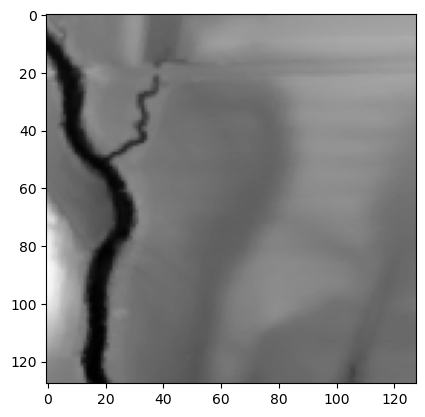

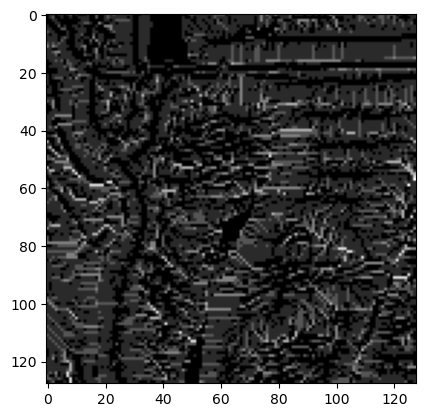

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(dem_image[0].squeeze(), cmap='gray')
plt.figure()
plt.imshow(so_image[0].squeeze(), cmap='gray')

In [8]:
test = so_image[0].squeeze()
dem_test = dem_image[0].squeeze()

In [ ]:
test[:5,:5]

In [9]:
dem_test[:5,:5]

tensor([[-1.9928, -2.0097, -2.0150, -2.0136, -2.0115],
        [-1.9890, -2.0057, -2.0058, -2.0081, -2.0106],
        [-1.9822, -2.0135, -2.0085, -2.0063, -2.0031],
        [-1.9835, -1.9908, -2.0103, -2.0104, -1.9972],
        [-2.0047, -1.9845, -1.9920, -2.0173, -2.0033]])

In [ ]:
import numpy as np
from torchvision import datasets, transforms

# Step 1: Create a Dataset Object with No Transformations
# dataset = datasets.ImageFolder(root='../../dem2so/', transform=transforms.ToTensor())

# Step 2: Initialize Variables for Mean and Standard Deviation
mean = 0.0
std = 0.0

# Step 3: Compute Mean and Standard Deviation
for batch in train_loader:
    img = batch['DEM']
    mean += img.mean()  # Compute mean for the single channel
    std += img.std()    # Compute std deviation for the single channel

# Step 4: Calculate Final Mean and Standard Deviation
num_samples = len(dataset)
mean /= num_samples
std /= num_samples

# Step 5: Print or Use the Calculated Values
print("Mean:", mean)
print("Standard Deviation:", std)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet_1(n_channels=1, n_classes=9, dropout_rate=0.5).to(device)  # Change n_classes based on your output


cuda


In [12]:
model.eval() 
batch = next(iter(val_loader))
dem_image = batch['DEM']
so_image = batch['SO']
dem_image, so_image = dem_image.to(device), so_image.to(device)  # Move data to GPU
val_outputs = model(dem_image)

In [46]:
def mIOU(label, pred, num_classes=9):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
#             print(present_iou_list)
        iou_list.append(iou_now)
    return np.mean(present_iou_list), iou_list, present_iou_list

In [42]:
def calculate_metrics(predicted, desired, num_classes=9):
    """
    Calculate accuracy, mean IoU and mean Dice coefficient for one-hot encoded predicted map 
    and single-channel desired map.

    :param predicted: Predicted tensor (one-hot encoded).
    :param desired: Desired (ground truth) tensor (single-channel with class labels).
    :param num_classes: Number of classes in the data.
    :return: Accuracy, mean IoU, mean Dice coefficient.
    """
    predicted = predicted.cpu().detach().numpy()
    desired = desired.cpu().detach().numpy()

    # Convert desired map to one-hot encoding
    desired_one_hot = np.eye(num_classes)[desired.astype(np.int32)]
    desired_one_hot = desired_one_hot.transpose(0,3,2,1)
    # print(desired_one_hot.shape)
    # print(predicted.shape)

    accuracy = np.mean(np.argmax(predicted, axis=1) == np.argmax(desired_one_hot, axis=1))

    iou_list = []
    dice_list = []

    for cls in range(num_classes):
        predicted_cls = predicted[:, cls, :, :]
        desired_cls = desired_one_hot[:, cls, :, :]

        intersection = np.logical_and(predicted_cls, desired_cls)
        union = np.logical_or(predicted_cls, desired_cls)

        if np.sum(union) == 0:  # Avoid division by zero
            iou = np.nan
            dice = np.nan
        else:
            iou = np.sum(intersection) / np.sum(union)
            dice = 2 * np.sum(intersection) / (np.sum(predicted_cls) + np.sum(desired_cls))

#         print(iou)
        iou_list.append(iou)
        dice_list.append(dice)

    # Compute mean IoU and Dice, ignoring NaN values
    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)

    return accuracy, mean_iou, mean_dice

In [27]:
mIOU(so_image, val_outputs)

[0.0]
[0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0024415552707074406]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0024415552707074406, 0.0]


0.0003051944088384301

In [21]:
acc, iou, dice = calculate_metrics(val_outputs, so_image)

0.21099853515625
0.5606689453125
0.13629150390625
0.06011962890625
0.02203369140625
0.0062255859375
0.00244140625
0.001220703125
0.0


In [22]:
pred = F.softmax(val_outputs, dim=1)              
pred = torch.argmax(val_outputs, dim=1).squeeze(1)

In [25]:
pred.min()

tensor(6, device='cuda:0')

In [29]:
import wandb

In [30]:
wandb.init()

wandb: Currently logged in as: stmmc (tousi-team). Use `wandb login --relogin` to force relogin


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/dem2so/dem'
so_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/dem2so/so'

In [33]:
transform = RasterTransform()

dataset = RasterTilesDataset(dem_dir=dem_dir, so_dir=so_dir, transform=transform)

In [53]:
batch_size = 1
learning_rate = 0.0001
epochs = 10
number_of_workers = 1
# image_size = arg_imagesize
val_percent = 0.1

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True, drop_last=True)

print("Data is loaded")

Data is loaded


In [54]:
model = UNet_1(n_channels=1, n_classes=9, dropout_rate=0.5).to(device)

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import numpy as np
from tqdm import tqdm

# criterion = nn.CrossEntropyLoss()  # Replace with your loss function
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
model.load_state_dict(torch.load('./model_epoch_400.pth'))

<All keys matched successfully>

In [61]:
model.eval()  # Set the model to evaluation mode
arg_nottest = True
val_metrics = {'Validation/iou': 0}
iou_all = []
with torch.no_grad():
    val_correct = 0
    val_total = 0
    for batch in tqdm(val_loader):
        dem_image = batch['DEM']
        so_image = batch['SO']
        dem_image, so_image = dem_image.to(device), so_image.to(device)  # Move data to GPU
        val_outputs = model(dem_image)  # Forward pass
        loss = criterion(val_outputs, so_image)
        iou, iou_list, iou_present = mIOU(so_image, val_outputs)
        # val_metrics['Validation/accuracy'] += acc
        val_metrics['Validation/iou'] += iou
        iou_all.append(iou_list)
        # val_metrics['Validation/dice'] += dice

        if arg_nottest:
            continue
        else:
            break

    if arg_nottest:
        for k in val_metrics:
            val_metrics[k] /= len(val_loader)

#     if args.logging:
#         wandb.log(val_metrics)
#         wandb.log({'Validation/Loss':loss.item()})

#         if (epoch + 1) % arg_savingstep == 0:

#             torch.save(model.state_dict(), f'./model_epoch_{epoch+1}.pth')
#             artifact = wandb.Artifact(f'model_epoch_{epoch+1}', type='model')
#             artifact.add_file(f'./model_epoch_{epoch+1}.pth')
#             wandb.log_artifact(artifact)
#             # save_comparison_figures(model, val_loader, epoch + 1, device)

    print(val_metrics)

100%|█████████████████████████████████████████████████████████| 258/258 [00:45<00:00,  5.64it/s]

{'Validation/iou': 0.34148625409937294}


In [67]:
batch = next(iter(val_loader))
dem_image = batch['DEM']
so_image = batch['SO']
dem_image, so_image = dem_image.to(device), so_image.to(device)  # Move data to GPU
val_outputs = model(dem_image)  # Forward pass
loss = criterion(val_outputs, so_image)
iou, iou_list, present_iou = mIOU(so_image, val_outputs)

In [60]:
torch.cuda.empty_cache()

In [58]:
iou_list

[0.615752333257455,
 0.6653693132676007,
 0.2658769332017111,
 0.1651045421773612,
 0.18181818181818182,
 0.13142857142857142,
 0.25806451612903225,
 nan,
 nan]

In [59]:
present_iou

[0.615752333257455,
 0.6653693132676007,
 0.2658769332017111,
 0.1651045421773612,
 0.18181818181818182,
 0.13142857142857142,
 0.25806451612903225]

In [63]:
iou_all_array = np.array(iou_all)

In [66]:
np.nanmean(iou_all_array, axis=0)

array([6.57845164e-01, 6.87775937e-01, 2.95249150e-01, 2.19791308e-01,
       1.99760958e-01, 1.80128901e-01, 1.55983437e-01, 5.63063063e-04,
       0.00000000e+00])

In [78]:
pred = F.softmax(val_outputs, dim=1)              
pred = torch.argmax(pred, dim=1).squeeze(1)

numpy_pred = pred.cpu().numpy().squeeze()
numpy_target = so_image.cpu().numpy().squeeze()


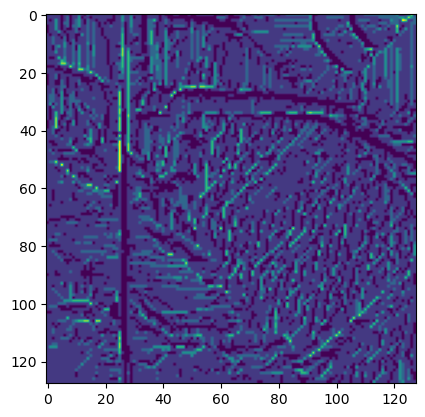

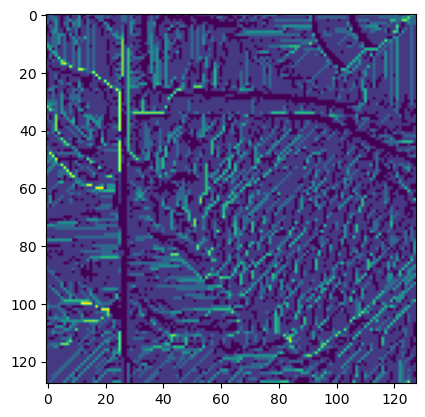

In [84]:
plt.figure()
plt.imshow(numpy_pred)
plt.figure()
plt.imshow(numpy_target)

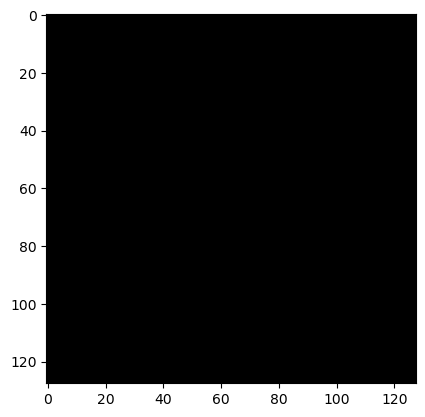

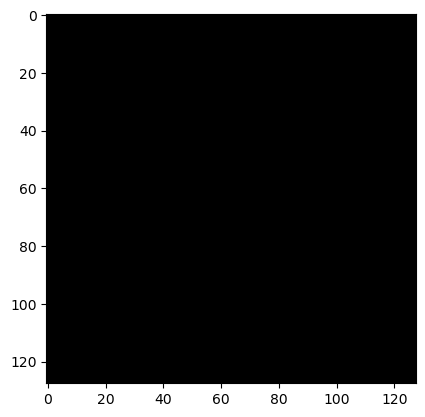

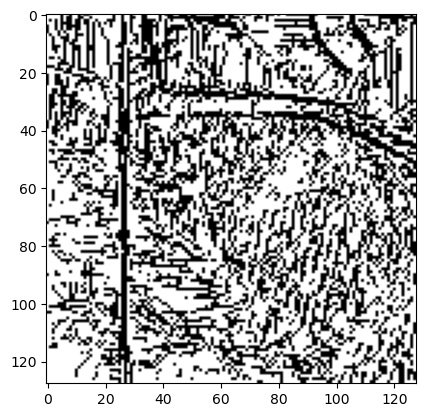

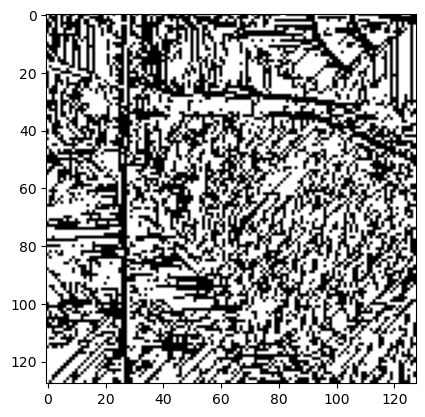

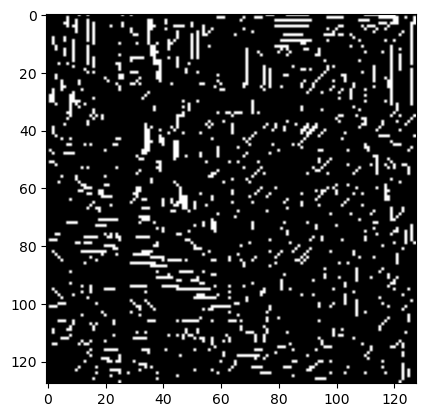

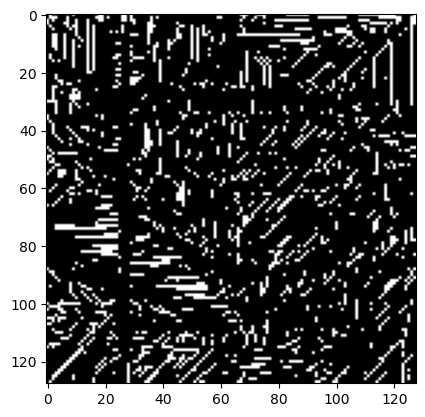

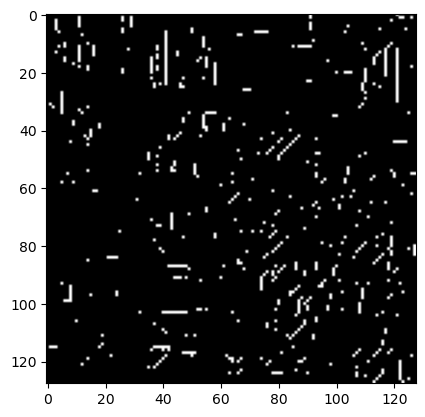

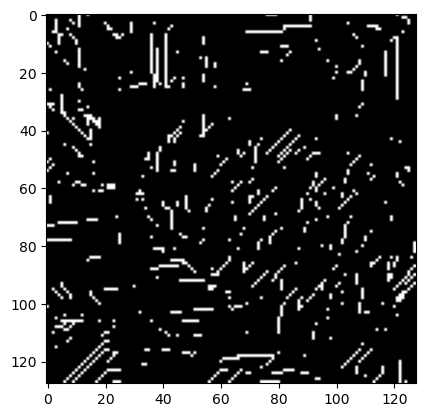

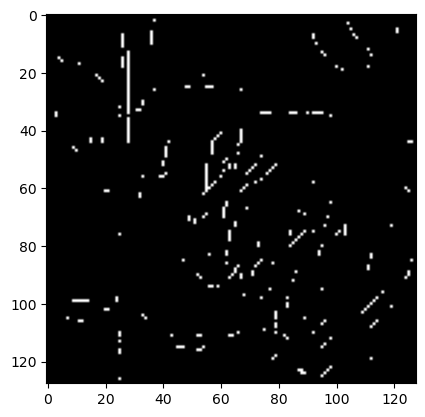

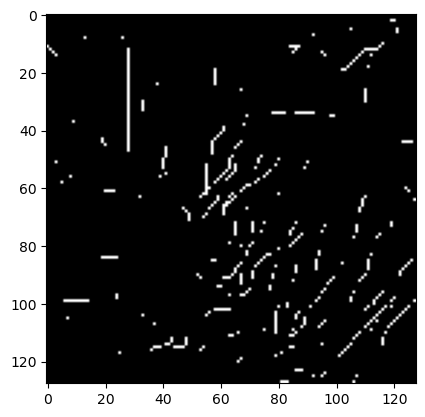

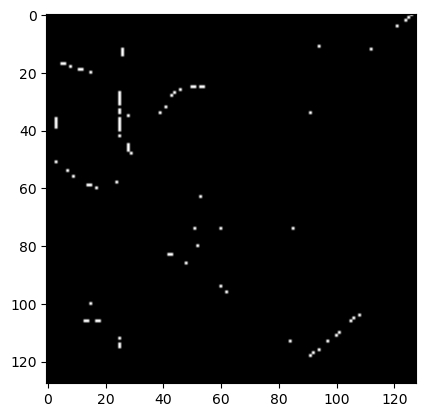

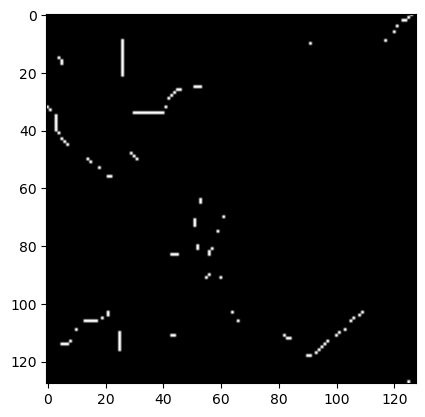

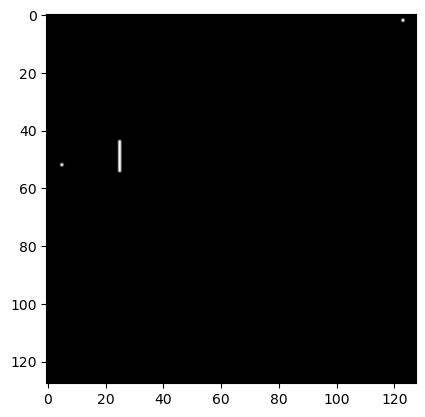

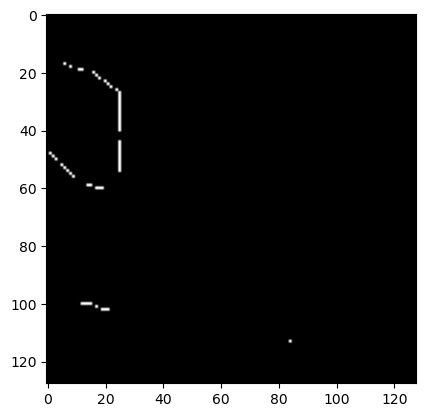

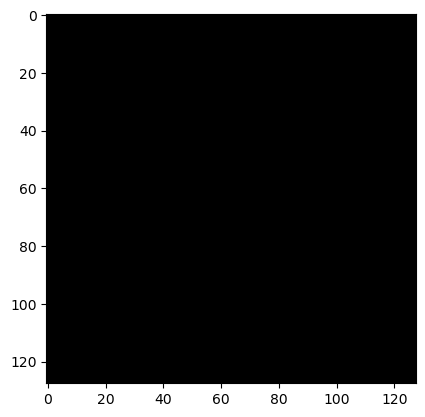

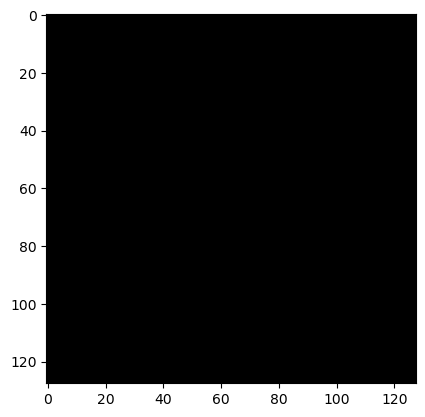

In [83]:
for i in range(8):
    
    pred_mask = numpy_pred == i
    so_mask = numpy_target == i
    
    pred_filtered = np.where(pred_mask, numpy_pred, 0)
    so_filter = np.where(so_mask, numpy_target, 0)


    plt.figure()
    plt.imshow(pred_filtered, cmap='gray')
    plt.figure()
    plt.imshow(so_filter, cmap='gray')

In [82]:
numpy_pred.shape

(128, 128)

# TF to Pytorch

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

2024-01-19 16:31:30.892165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 16:31:31.811214: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 16:31:32.027353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/li

In [2]:
model = ResNet50(include_top=True, weights=None, classes=19)

2024-01-19 16:31:49.399762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-19 16:31:49.399922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2024-01-19 16:31:49.403576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-p

In [3]:
checkpoint_path = "../../models/TF/ResNet50/"

In [6]:
tf.compat.v1.disable_eager_execution()


In [ ]:
with tf.compat.v1.Session() as sess:
    # Load the meta graph
    saver = tf.compat.v1.train.import_meta_graph('../../models/TF/ResNet50/ResNet50_BigEarthNet_original_labels.meta')
    
    # Restore the weights
    saver.restore(sess, tf.train.latest_checkpoint(''))


# Pytorch RGBDEM2SO

In [5]:
from os.path import splitext
from os import listdir
import numpy as np
import os
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
# from libtiff import TIFF
import cv2
from torchvision.transforms import functional as TF
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

class RGB_RasterTilesDataset(Dataset):
    def __init__(self, dem_dir, so_dir, rgb_dir, transform=None):
        """
        Custom dataset to load DEM, SO, and RGB tiles.

        :param dem_dir: Directory where DEM tiles are stored.
        :param so_dir: Directory where SO tiles are stored.
        :param rgb_dir: Directory where RGB tiles are stored.
        :param transform: Optional transform to be applied on a sample.
        """
        self.dem_dir = dem_dir
        self.so_dir = so_dir
        self.rgb_dir = rgb_dir
        self.transform = transform

        self.filenames = [f for f in os.listdir(dem_dir) if os.path.isfile(os.path.join(dem_dir, f))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        dem_file = os.path.join(self.dem_dir, self.filenames[idx])
        so_file = os.path.join(self.so_dir, self.filenames[idx])
        # Assuming RGB tiles follow a similar naming convention
        rgb_files = [os.path.join(self.rgb_dir, f'rgb{k}_{self.filenames[idx]}') for k in range(6)]

        dem_image = Image.open(dem_file)
        so_image = Image.open(so_file)
        rgb_images = [Image.open(file) for file in rgb_files]

        dem_array = np.array(dem_image)
        so_array = np.array(so_image)
        rgb_arrays = [np.array(image) for image in rgb_images]

        sample = {'DEM': dem_array, 'SO': so_array, 'RGB': rgb_arrays}

        if self.transform:
            sample = self.transform(sample)

        return sample